<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Evaluation_Metrics_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.10.4 (main, Mar 23 2022, 20:25:24) [GCC 11.3.0]


In [ ]:
!pip install --upgrade tensorflow==2.12.1

In [ ]:
!pip install gitpython

In [ ]:
import os
from git.repo.base import Repo
Repo.clone_from("https://github.com/jeslago/epftoolbox", "epftoolbox")

In [2]:
cd epftoolbox

/home/souhir/sciebo/Souhir/epftoolbox


In [3]:
from epftoolbox.evaluation import MAE, RMSE, MAPE, sMAPE, MASE, rMAE
import pandas as pd
from epftoolbox.evaluation import naive_forecast

In [ ]:
import pandas as pd
import numpy as np

# Define robust sMAPE function
def sMAPE(p_pred, p_real):
    p_pred = np.array(p_pred)
    p_real = np.array(p_real)
    denominator = np.abs(p_real) + np.abs(p_pred)
    diff = np.abs(p_real - p_pred)

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        smape = 2 * diff / denominator
        smape[denominator == 0] = 0  # Safe handling

    return np.mean(smape) * 100

# Assuming MAE, RMSE, MAPE, MASE, rMAE are defined already...

# Reading the forecast data
forecast = pd.read_excel('Final_Forecasting Results 2019-2020.xlsx')
forecast.reset_index(inplace=True)
forecast["Date"] = pd.to_datetime(forecast["Date"])
forecast = forecast.set_index('Date')

# Extracting the real price
real_price = forecast.iloc[:, 1]

# Reading the full sample data for the naive forecast calculation
df = pd.read_excel('EPF_2015_2020.xlsx')
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Consider the train sample for the naive forecast calculation
y_train = df[:-17640]
real_price_insample = y_train.iloc[:, 1]
real_price_insample = pd.DataFrame(real_price_insample)

# Calculate the naive forecast
naive_fc = naive_forecast(p_real=real_price_insample, m='W', n_prices_day=24)

# Prepare a DataFrame to store the evaluation metrics results
metrics_list = []

# Calculate metrics for each forecasted column
for col in forecast.columns[2:]:
    fc_model = forecast[col]
    metrics = {
        'Model': col,
        'MAE': MAE(p_pred=fc_model, p_real=real_price),
        'RMSE': RMSE(p_pred=fc_model, p_real=real_price),
        'sMAPE': sMAPE(p_pred=fc_model, p_real=real_price),  # Use corrected sMAPE
        'MASE': MASE(p_pred=fc_model, p_real=real_price, p_real_in=real_price_insample, m='W'),
        'rMAE': rMAE(p_pred=fc_model, p_real=real_price)
    }
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

# Convert to LaTeX table — explicitly control column order
latex_table = metrics_df[['MAE', 'RMSE', 'sMAPE', 'MASE', 'rMAE']].to_latex(index=True, float_format="%.4f")

# Show LaTeX table
print(latex_table)


\begin{tabular}{lrrrrr}
\toprule
 & MAE & RMSE & sMAPE & MASE & rMAE \\
Model &  &  &  &  &  \\
\midrule
ESM & 6.1009 & 9.3665 & 23.9509 & 0.6375 & 0.6545 \\
Ens--DNN & 4.2482 & 7.1899 & 19.1267 & 0.4439 & 0.4557 \\
Ens--LEAR & 4.0659 & 6.8218 & 19.8103 & 0.4248 & 0.4362 \\
DNN  & 5.0514 & 8.2359 & 21.2631 & 0.5278 & 0.5419 \\
LEAR  & 4.1086 & 6.9749 & 19.3627 & 0.4293 & 0.4408 \\
LSTM & 4.8075 & 7.6839 & 21.4211 & 0.5023 & 0.5157 \\
LARX & 8.7149 & 11.1573 & 30.5276 & 0.9106 & 0.9349 \\
RF & 14.4096 & 16.8145 & 42.8504 & 1.5057 & 1.5458 \\
ESM--Ens-DNN + & 3.4851 & 5.8911 & 16.6317 & 0.3642 & 0.3739 \\
ESM—Ens--LEAR+ & 3.6693 & 6.0980 & 17.7151 & 0.3834 & 0.3936 \\
ESM--DNN+ & 3.7629 & 6.3577 & 17.6838 & 0.3932 & 0.4037 \\
ESM--LEAR+ & 3.8341 & 6.2832 & 17.9657 & 0.4006 & 0.4113 \\
ESM—LSTM+ & 4.4174 & 7.3877 & 19.9509 & 0.4616 & 0.4739 \\
ESM—LARX+ & 7.6550 & 9.9655 & 27.9208 & 0.7999 & 0.8212 \\
ESM--RF+ & 6.8015 & 9.3391 & 28.0271 & 0.7107 & 0.7296 \\
ESM—Ens--DNN & 3.8384 & 6.2446

In [78]:
from epftoolbox.evaluation import DM, plot_multivariate_DM_test
from epftoolbox.data import read_data
import pandas as pd

In [ ]:
 # Generating forecasts of multiple models
 # Download available forecast of the NP market available in the library repository
 # These forecasts accompany the original paper
forecasts = pd.read_excel('Final_Forcasting_results_2023-2024_Final.xlsx', index_col=0)
forecasts

,Real,ESM,Ens-DNN,DNN,Ens-LEAR,LEAR,LSTM,LARX,RF,ESM-Ens-DNN+,...,ESM-LSTM+,ESM-LARX+,ESM-RF+,ESM-Ens-DNN,ESM-DNN,ESM-Ens-LEAR,ESM-LEAR,ESM-LSTM,ESM-LARX,ESM-RF
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,-1.07,10.398859,-11.912372,-13.408733,-11.715001,-15.821536,-1.334924,50.623460,10.12415,-14.792486,...,-36.806546,22.202565,-1.398025,-11.252902,-3.105333,-14.761835,-14.472571,14.926722,-0.357044,-0.870450
2023-01-01 01:00:00,-1.47,10.398859,-14.693109,-16.949844,-16.033335,-22.393460,-25.556855,46.528870,9.94845,-19.589090,...,-62.922169,20.923442,-1.398025,-15.620424,-9.184921,-20.783782,-22.156046,12.165386,-0.357044,-0.870450
2023-01-01 02:00:00,-5.08,10.398859,-15.311572,-22.840496,-20.571629,-23.972656,-29.455923,44.832425,9.78615,-19.213161,...,-77.294559,20.508546,-1.170475,-17.231594,-7.065662,-28.145303,-29.562969,11.132575,-0.357044,-0.870450
2023-01-01 03:00:00,-4.49,10.398859,-12.367088,-24.850136,-21.559018,-17.341502,-29.911715,45.596559,9.78615,-25.064529,...,-79.154099,20.861937,-1.150050,-19.488720,-4.402296,-35.170117,-29.400860,9.196432,-0.357044,-0.870450
2023-01-01 04:00:00,-5.40,-20.000000,-18.698764,-25.529030,-31.138218,-20.326731,-26.074627,44.920089,9.88915,-30.566366,...,-76.262913,-3.365520,-2.817275,-18.120173,-8.627159,-58.116976,-51.244800,7.758368,-41.895731,-4.502350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,35.56,70.662823,43.991351,46.437477,64.727936,69.091701,67.559219,37.910193,32.73975,43.739990,...,69.946932,58.466416,54.483025,40.257395,36.922283,33.399759,40.947740,92.999852,82.214776,74.117200
2024-12-31 20:00:00,15.70,38.412434,36.461931,37.582703,63.082585,63.331435,56.026132,28.274479,9.43590,34.695427,...,60.568869,30.482930,13.170225,30.525607,31.241688,25.804202,27.758426,71.932309,38.646414,37.389750
2024-12-31 21:00:00,9.06,36.404494,30.328245,30.559753,62.031124,61.332712,45.324190,19.583065,-0.07570,31.399791,...,47.587451,26.001140,12.656375,27.848824,27.976772,28.745093,26.263699,37.662557,35.933806,35.354225


In [80]:
# Deleting the real price field as it the actual real price and not a forecast
del forecasts['Real']

forecasts

,ESM,Ens-DNN,DNN,Ens-LEAR,LEAR,LSTM,LARX,RF,ESM-Ens-DNN+,ESM-DNN+,...,ESM-LSTM+,ESM-LARX+,ESM-RF+,ESM-Ens-DNN,ESM-DNN,ESM-Ens-LEAR,ESM-LEAR,ESM-LSTM,ESM-LARX,ESM-RF
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,10.398859,-11.912372,-13.408733,-11.715001,-15.821536,-1.334924,50.623460,10.12415,-14.792486,-31.027718,...,-36.806546,22.202565,-1.398025,-11.252902,-3.105333,-14.761835,-14.472571,14.926722,-0.357044,-0.870450
2023-01-01 01:00:00,10.398859,-14.693109,-16.949844,-16.033335,-22.393460,-25.556855,46.528870,9.94845,-19.589090,-43.050583,...,-62.922169,20.923442,-1.398025,-15.620424,-9.184921,-20.783782,-22.156046,12.165386,-0.357044,-0.870450
2023-01-01 02:00:00,10.398859,-15.311572,-22.840496,-20.571629,-23.972656,-29.455923,44.832425,9.78615,-19.213161,-43.376949,...,-77.294559,20.508546,-1.170475,-17.231594,-7.065662,-28.145303,-29.562969,11.132575,-0.357044,-0.870450
2023-01-01 03:00:00,10.398859,-12.367088,-24.850136,-21.559018,-17.341502,-29.911715,45.596559,9.78615,-25.064529,-53.285023,...,-79.154099,20.861937,-1.150050,-19.488720,-4.402296,-35.170117,-29.400860,9.196432,-0.357044,-0.870450
2023-01-01 04:00:00,-20.000000,-18.698764,-25.529030,-31.138218,-20.326731,-26.074627,44.920089,9.88915,-30.566366,-64.285843,...,-76.262913,-3.365520,-2.817275,-18.120173,-8.627159,-58.116976,-51.244800,7.758368,-41.895731,-4.502350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,70.662823,43.991351,46.437477,64.727936,69.091701,67.559219,37.910193,32.73975,43.739990,53.250824,...,69.946932,58.466416,54.483025,40.257395,36.922283,33.399759,40.947740,92.999852,82.214776,74.117200
2024-12-31 20:00:00,38.412434,36.461931,37.582703,63.082585,63.331435,56.026132,28.274479,9.43590,34.695427,43.250359,...,60.568869,30.482930,13.170225,30.525607,31.241688,25.804202,27.758426,71.932309,38.646414,37.389750
2024-12-31 21:00:00,36.404494,30.328245,30.559753,62.031124,61.332712,45.324190,19.583065,-0.07570,31.399791,37.276932,...,47.587451,26.001140,12.656375,27.848824,27.976772,28.745093,26.263699,37.662557,35.933806,35.354225


In [81]:
# Transforming indices to datetime format
forecasts.index = pd.to_datetime(forecasts.index)
forecasts

,ESM,Ens-DNN,DNN,Ens-LEAR,LEAR,LSTM,LARX,RF,ESM-Ens-DNN+,ESM-DNN+,...,ESM-LSTM+,ESM-LARX+,ESM-RF+,ESM-Ens-DNN,ESM-DNN,ESM-Ens-LEAR,ESM-LEAR,ESM-LSTM,ESM-LARX,ESM-RF
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,10.398859,-11.912372,-13.408733,-11.715001,-15.821536,-1.334924,50.623460,10.12415,-14.792486,-31.027718,...,-36.806546,22.202565,-1.398025,-11.252902,-3.105333,-14.761835,-14.472571,14.926722,-0.357044,-0.870450
2023-01-01 01:00:00,10.398859,-14.693109,-16.949844,-16.033335,-22.393460,-25.556855,46.528870,9.94845,-19.589090,-43.050583,...,-62.922169,20.923442,-1.398025,-15.620424,-9.184921,-20.783782,-22.156046,12.165386,-0.357044,-0.870450
2023-01-01 02:00:00,10.398859,-15.311572,-22.840496,-20.571629,-23.972656,-29.455923,44.832425,9.78615,-19.213161,-43.376949,...,-77.294559,20.508546,-1.170475,-17.231594,-7.065662,-28.145303,-29.562969,11.132575,-0.357044,-0.870450
2023-01-01 03:00:00,10.398859,-12.367088,-24.850136,-21.559018,-17.341502,-29.911715,45.596559,9.78615,-25.064529,-53.285023,...,-79.154099,20.861937,-1.150050,-19.488720,-4.402296,-35.170117,-29.400860,9.196432,-0.357044,-0.870450
2023-01-01 04:00:00,-20.000000,-18.698764,-25.529030,-31.138218,-20.326731,-26.074627,44.920089,9.88915,-30.566366,-64.285843,...,-76.262913,-3.365520,-2.817275,-18.120173,-8.627159,-58.116976,-51.244800,7.758368,-41.895731,-4.502350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,70.662823,43.991351,46.437477,64.727936,69.091701,67.559219,37.910193,32.73975,43.739990,53.250824,...,69.946932,58.466416,54.483025,40.257395,36.922283,33.399759,40.947740,92.999852,82.214776,74.117200
2024-12-31 20:00:00,38.412434,36.461931,37.582703,63.082585,63.331435,56.026132,28.274479,9.43590,34.695427,43.250359,...,60.568869,30.482930,13.170225,30.525607,31.241688,25.804202,27.758426,71.932309,38.646414,37.389750
2024-12-31 21:00:00,36.404494,30.328245,30.559753,62.031124,61.332712,45.324190,19.583065,-0.07570,31.399791,37.276932,...,47.587451,26.001140,12.656375,27.848824,27.976772,28.745093,26.263699,37.662557,35.933806,35.354225


In [ ]:
#Extracting the real prices from the market
df = pd.read_csv('EPF_data_2023-2024.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df

,Prices,Demand Day-ahead DE,Wind and PV Day ahead (MWh/h),Gas,Coal,CO2
Date,,,,,,
2019-01-01 00:00:00,10.07,41662.750000,25668.75,21.980,75.44,24.73
2019-01-01 01:00:00,-4.08,40553.000000,27384.00,21.980,75.44,24.73
2019-01-01 02:00:00,-9.91,40261.250000,29010.25,21.980,75.44,24.73
2019-01-01 03:00:00,-7.41,40603.250000,30359.25,21.980,75.44,24.73
2019-01-01 04:00:00,-12.55,40904.250000,31409.25,21.980,75.44,24.73
...,...,...,...,...,...,...
2024-12-31 20:00:00,15.70,52497.653679,42510.00,50.525,110.06,71.14
2024-12-31 21:00:00,9.06,49201.667324,42708.75,50.525,110.06,71.14
2024-12-31 22:00:00,0.52,47257.128235,43088.00,50.525,110.06,71.14


In [85]:
y_test = df[-17544:]
real_price = y_test.loc[:, ['Prices']]

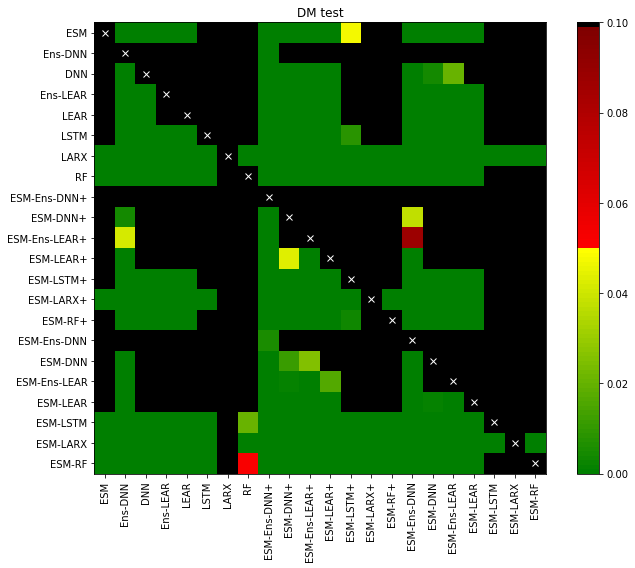

<Figure size 432x288 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))          # ← increase width, height in inches
plot_multivariate_DM_test(
    real_price=real_price,
    forecasts=forecasts
)
plt.tight_layout()                   # ← make sure labels aren’t cut off
plt.show()
